# Module 6 - MonteCarlo

Nous commençons par importer les différents package et raccourcis nécessaires à notre code.

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from numpy import random, sqrt, log, sin, cos, pi, arange, exp, linspace, extract
from pylab import show, hist, subplot, figure, plot, xlim, ylim
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

## Notebook 2 - Random numbers

### Challenge 1
1) Python has many built-in random number generators. Check-out the documentation and try a couple of ones. In particular, compare the output of the built-in exponential and Gaussian generators with the versions implemented above.

Reprenons le générateur de distribution exponentielle du notebook pour le comparer à celui donné directement par numpy.

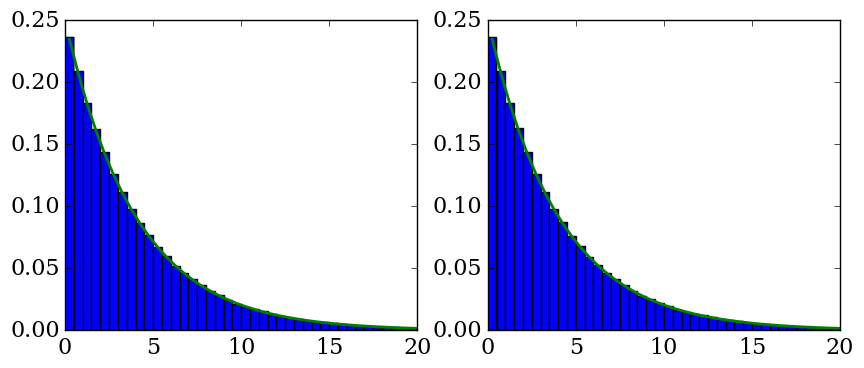

In [2]:
N = 1000000

figure(figsize=(10,4))

#Nous implémentons la version du notebook
subplot(1,2,1) # left graph

alpha = 0.25 # rate of the exponential distribution
x = random.random_sample(N)
y = -1/alpha*log(1-x)

# Plots
binwidth = 0.5
xlim(0,20)
bins = arange(0.,21., binwidth)
hist(y,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plot(xc,alpha*exp(-alpha*xc), lw=2)


#Nous implémentons maintenant la version de numpy
subplot(1,2,2) # right graph

lambd = 1/alpha
randexp = []
for i in range (N):
    x = random.exponential(lambd) # We use the built-in exponential generator.
    randexp.append(x)
    
# Plots
binwidth=0.5
xlim(0,20)
bins=arange(0.,21., binwidth)
hist(randexp,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plot(xc,alpha*numpy.exp(-alpha*xc), lw=2)

show()

Nous voyons bien que les deux implémentations créent des histogrammes assez semblables.

Maintenant nous allons comparer le générateur de gaussienne du notebook qui est implémenté à l'aide de la "Von Neumann rejection method" et le générateur de numpy.

Acceptance ratio: 0.713674


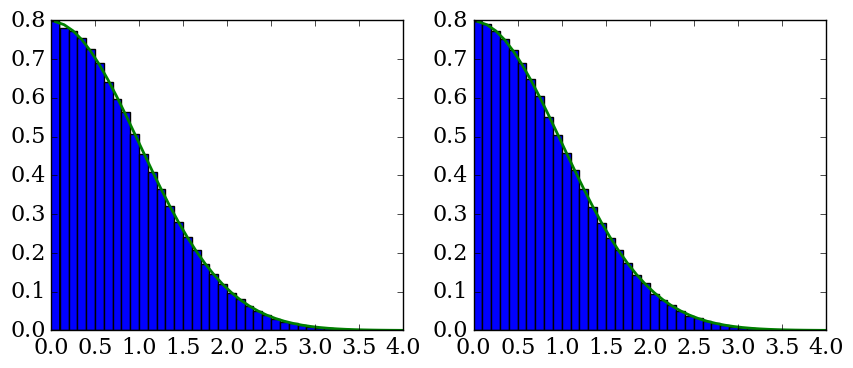

In [3]:
figure(figsize=(10,4))

# Version du notebook
subplot(1,2,1) # left graph
# Number of random numbers to draw according to p1 
N = 1000000
K = 1.4

# Empty list for the final set of numbers
h=[]

# Distribute g according to the exponential distribution
uniform1 = random.random_sample(N)
g = log(1/(1-uniform1))

# Probabilty of drawing g according to the exponential distribution
p_g_exp = exp(-g)

# Probability of drawing g according to the (positive) normal distribution
p_g_gauss = 2.0*exp(-g**2/2.0)/sqrt(2*pi)

# Draw a second uniform distribution for the acceptance
uniform2 = random.random_sample(N)

# Create acceptance mask
condition = uniform2 < p_g_gauss / (1.4*p_g_exp )

# Extract the accepted random numbers
h = extract(condition,g)

# Print the acceptance ratio
print("Acceptance ratio:",h.size/g.size)

# Plots
binwidth=0.1
bins=arange(0.,5.1, binwidth)
hist(h,bins,normed='true',color='blue');
ylim(0.,0.8)
xlim(0,4)
# Compute centers of bins
xc = bins[:-1] + binwidth/2
plot(xc,2*exp(-xc**2/2.0)/sqrt(2*pi),lw=2,color='green')


# Et voici la version de numpy


subplot(1,2,2) # right graph

nx = 1000000
mu, sigma = 0, 1 # mean and standard deviation
randgauss=[]
xi = linspace(0,5,nx)
for j in range(nx):
    y = random.normal(mu, sigma) #gaussian random number generator from numpy
    if (y >= 0):
        randgauss.append(y)
    else: j = j-1

# Plots        
binwidth = 0.1
xlim(0.,4.)
ylim(0.,0.8)
bins=arange(0.,5., binwidth)
hist(randgauss,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plot(xc,2*exp(-xc**2/2.0)/sqrt(2*pi), lw=2, color='g')

On retrouve une correspondance entre les deux méthodes.

### Challenge 2
2) Another popular method to generate numbers according to the Gaussian distribution is known as the Box–Muller algorithm. Look up its definition on the web, try to implement it and verify that it works as expected.

In [4]:
# Cette fonction a pour but de transformer des nombres distribués uniformément en des nombres distribués 
# selon une gaussienne. On peut sot utiliser la fonction avec le sinus, soit celle avec le cosinus.
def gauss(x,y):
    gen1 = sqrt(-2*log(x))*sin(2*y*pi)
    gen2 = sqrt(-2*log(x))*cos(2*y*pi)
    return gen1,gen2

In [5]:
nx = 1000000 # number of numbers 
x = random.rand(nx) # generate random numbers
y = random.rand(nx)
gen1,gen2 = gauss(x,y) # transform the numbers into a gaussian

Maintenant regardons les histogrammes des valeurs avant et après les transformations.

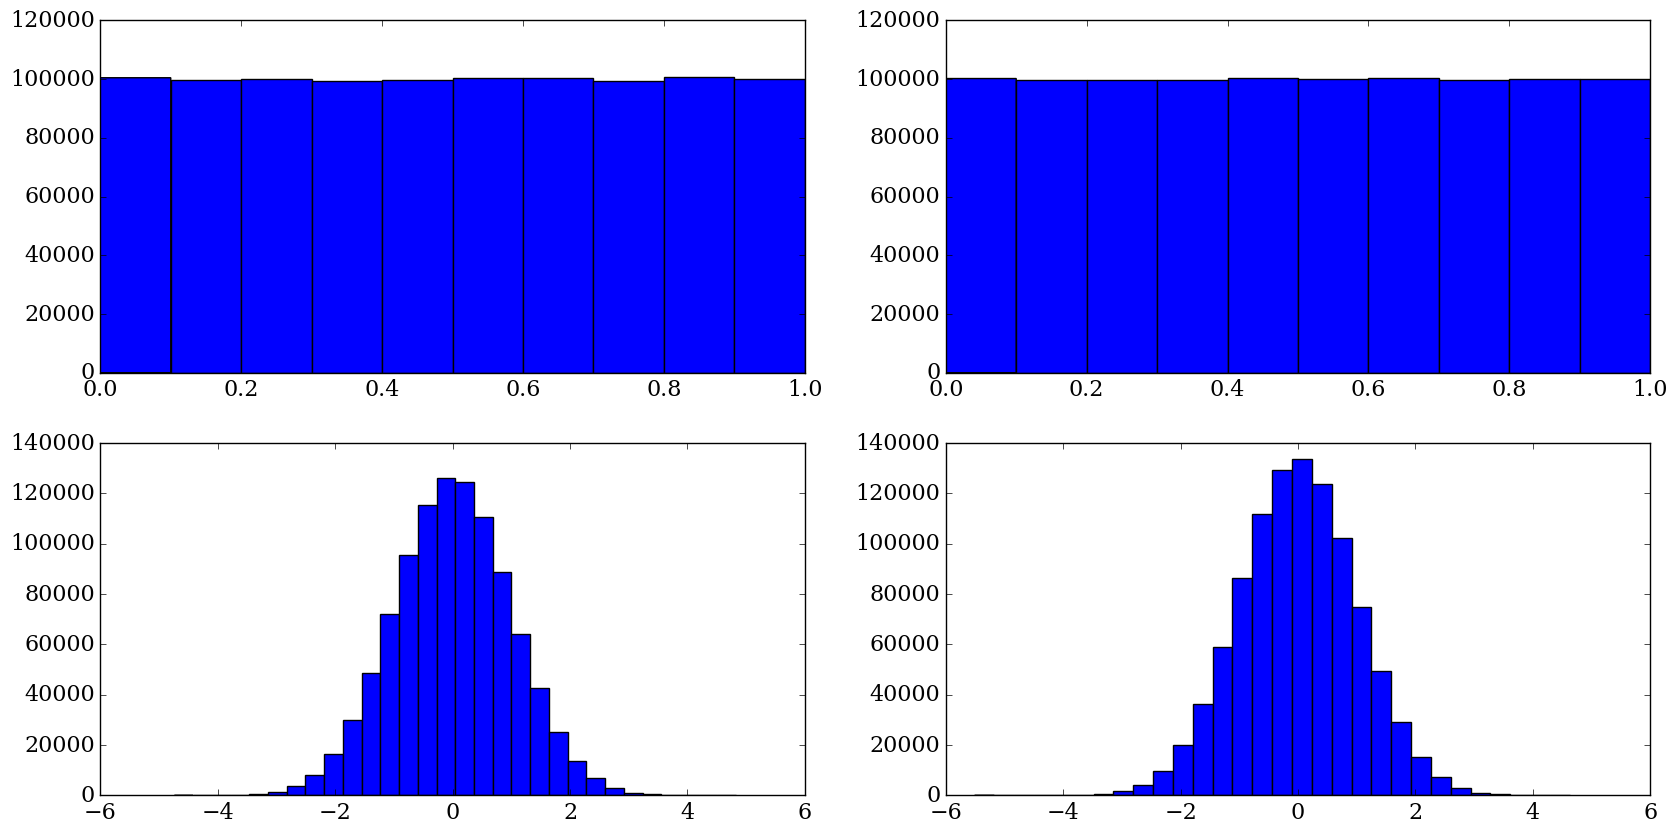

In [6]:
figure(figsize=(20,10))
binwidth = 0.1
subplot(2,2,1) # la première rangée de graph contient les distributions uniformes
hist(x)
subplot(2,2,2)
hist(y)
subplot(2,2,3) # la seconde rangée contient les distributions gaussiennes
hist(gen1,30)  
subplot(2,2,4)
hist(gen2,30)
show()

## Notebook 3 - Brownian motion (2)

### Equation stochastique pour le mouvement brownien

Nous avons l'équation d'évolution de la position pour une molécule de colorant est:

$$
dx=x(t+dt)−x(t)=ds
$$

$ds$ où ds est le déplacement qui découle de la collision avec les molécules d'eau qui l'entoure. Notre objectif est de caractériser ce déplacement. L'équation est dite stochastique car elle contient une contribution aléatoire.

Pour le mouvement brownien, on peut utiliser comme modèle pour ds:

$$
ds=\alpha \sqrt{dt}\cal{N(0,1)}
$$

avec $\alpha$ le coefficient de diffusion qu'on a déjà utilisé. De plus, à chaque pas temporel, on rajoute une contribution aléatoire générée par une distribution standard $\cal{N(0,1)}$ donnée par $f(n)$.

$$
f(n)=\frac{1}{\sqrt{2\pi}}e^{-\frac12 n^2}
$$

Pour simplifier, nous travaillerons en 1 dimension.

### Comparaison avec l'équation de diffusion

Nous allons suivre le parcours d'un échantillon de plusieurs molécules pour estimer l'évolution de notre colorant. On tire la densité d'après la position.

$$
\rho(x,t) dx=n(x,t)/N
$$

avec $n(x,t)$ qui nous donne, à un temps t, le nombre de molécules contenues dans un intervalles $dx$.

Nous allons tester notre modèle stochastique et faire la comparaison avec l'équation de diffusion, on initialise la position 0 avec une distribution gaussienne.

$$
P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$ 

avec $\sigma^2$ la variance des positions et $\mu$ leur moyenne. Comme $n(x,0)=NP(x)dx$, on a $\rho(x,0)=P(x)$. Dans ce cas, la solution de l'équation de diffusion 

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}
$$

peut être calculée et est donnée par:

$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}}
$$

avec $\sigma^2_t = 2\alpha t + \sigma^2$.

Le développement du notebook a prouvé que notre modèle suit bien l'équation de diffusion.

### Challenge 1
- Add as systematic contribution to the displacement $dx$,

$$
dx=cdt+\sqrt{2\alpha dt}\cal{N(0,1)}
$$

where $c$ is a constant and analyse the behaviour of the random walk. Can you guess the corresponding equation governing the evolution of the density in this case? What is the analitical solution for an initial Gaussian distribution?


Nous commençons par réutiliser les codes du notebook pour générer un certain nombre de partcules distribuées selon une gaussienne. Ensuite nous utilisons le code pour visualiser le déplacement de 20 d'entre elles afin de se faire une idée générale de ce qui se passe.

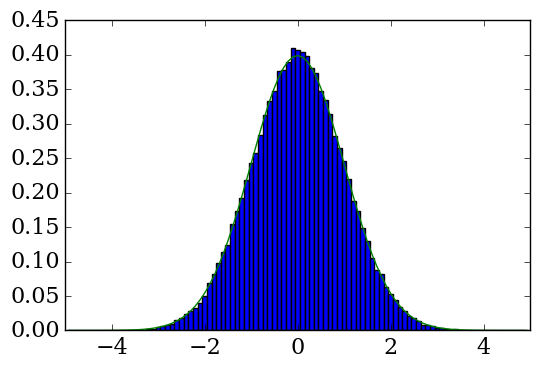

In [7]:
# Generate a set of initial positions based on the Gaussian distribution
npart = 100000

# We set mu=0
sigma = 1.0
x0 = random.normal(loc=0,scale=sigma,size=npart)

# Generate bins centered around 0
binwidth=0.1
bins=arange(-5,5,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# Plot the histogram and expected distribution
xlim(-5,5)
hist(x0,bins,normed=True);
plot(bin_centers, exp(-bin_centers**2/(2.0*sigma**2))/sqrt(2*pi*sigma**2))

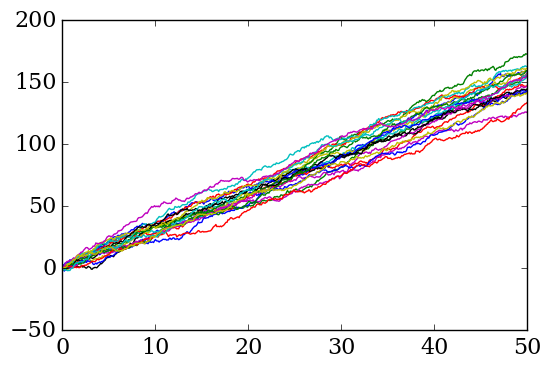

In [8]:
T=50.0
nt=500
dt=T/nt
alpha=2.0 # On garde le coefficient de diffusion du notebook.
c=3 # On essaye c = 3

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+c*dt+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)

for i in range(20):
    plot(t,x[:,i])
    

On voit que la distribution est très groupée en $T = 0$ et tend à s'étaler au fil du temps. En $T = 50$, elle parait centrée en $150$. En effet, cela a un sens physique, car l'ensemble des particules reçoit une contribution positive donnée par $cdt=3*50=150$ en $T = 50$.

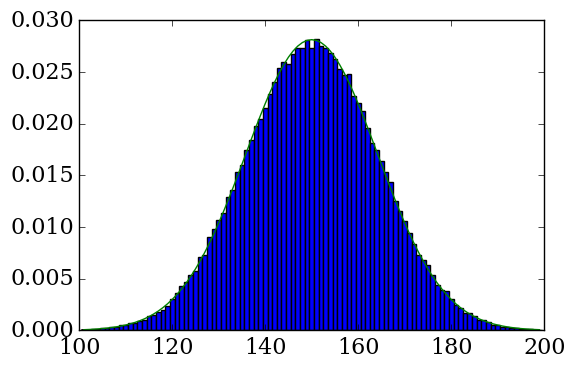

In [9]:
# On génère des "bins" autour de notre nouvelle moyenne
new_mu = c*T # on calcule la nouvelle moyenne 
binwidth=1
bins=arange(100,200,binwidth)
bins = bins + binwidth/2

# On calcule les centres des "bins"
bin_centers = bins[:-1]+binwidth/2

# On "plot" un histogramme pour vérifier
hist(x[nt],bins,normed=True);

# On regarde la distribution attendue, avec le même sigma que dans le notebook.
sigmat2=2*alpha*T+sigma**2
plot(bin_centers, exp(-(bin_centers-new_mu)**2/(2.0*sigmat2))/sqrt(2*pi*sigmat2))

On voit que l'histogramme et la distribution attendue concordent. La densité est donnée par 

$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu_n)^2}{2\sigma_t^2}}
$$

où $\mu_n$ corrrespond à new_mu dans le code.

### Challenge 2
- Simulate the following random walk with a 'friction' term:

$$
dx=-\gamma x dt + \sqrt{2\alpha dt}\cal{N(0,1)}
$$

Check that the distribution reaches a steady state for $t\rightarrow \infty$. Can you guess the corresponding equation governing the evolution of the density in this case? What is analytical form for the steady state? These last two questions are not easy!

Commençons par implémenter une fonction qui va nous donner une idée générale de la trajectoire des particules. Cette fonction dépend de plusieurs paramètres détaillés au fur et à mesure qu'ils apparaissent.

In [10]:
def trajfriction(T,nt,alpha,gamma,mu,sigma,npart):
    dt = T/nt                                 # intervalle de temps
    t = numpy.arange(0,T+dt,dt)               # axe temporel, sous forme de tableau
    x = numpy.empty([nt+1,npart])             # liste vide qui va contenir les trajectoires des différentes particules
    x0 = random.normal(loc=mu,scale=sigma,size=npart) # gaussienne qui définit la distribution initiale
    x[0]=x0

    for i in range(nt):                       # On calcule numériquement les trajectoires avec la fonction donnée dans
        x[i+1]=x[i]*(1-gamma*dt)+sqrt(2*alpha*dt)*random.normal(0,1,npart) # le challenge
   
    for i in range(20):                       # On plot la trajectoire de 20 particules
        plot(t,x[:,i])
    xnt = x[nt]                               # On stocke les positions aux temps T 
    return xnt

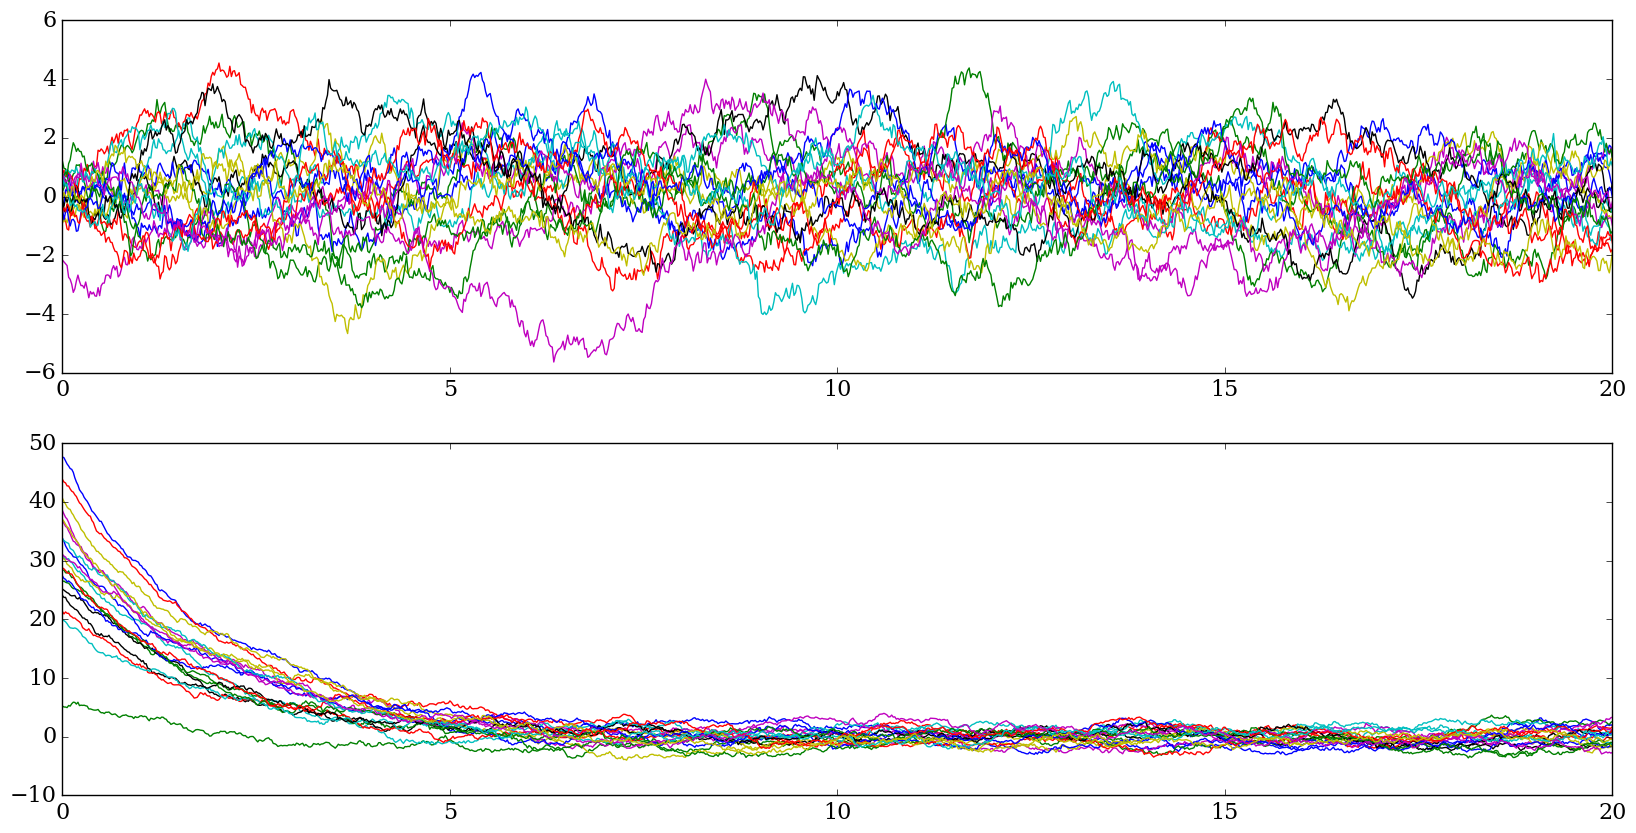

In [11]:
T=20                    # temps total
nt=1000                 # nombre d'intervalles temporels
alpha=1                 # coefficient de diffusion
gamma=0.5               # coefficient de friction

figure(figsize=(20,10))

subplot(2,1,1) # On regarde les trajectoires en partant de la distribution standard
mu = 0
sigma = 1.0
xnt1 = trajfriction(T,nt,alpha,gamma,mu,sigma,npart)

subplot(2,1,2) # Et avec une distribution gaussienne plus exotique
mu = 30
sigma = 10
xnt2 = trajfriction(T,nt,alpha,gamma,mu,sigma,npart)

On voit clairement que pour un temps long, les trajectoires tendent vers un état d'équilibre, et cela quel que soient les positions initiales des particules. Passons aux histogrammes pour analyser comment sont distribuéesles particules au temps T.

In [12]:
def histfriction(xnt): # Cette fonction crée un histogramme et une fonction analytique 
                       # à partir des positions des particules au temps T. 
    binwidth = 0.2
    bins = numpy.arange(-5,5,binwidth)
    bins = bins + binwidth/2
    bin_centers = bins[:-1] + binwidth/2
    hist(xnt,bins,normed=True,color='r');
    mu_T = 0           # La moyenne et l'écart-type au temps T sont expliqués plus loin.
    sigma_T = alpha/gamma
    plot(bin_centers, exp(-(bin_centers-mu_T)**2/(2.0*sigma_T))/sqrt(2*pi*sigma_T))

- Nous émettons l'hypothèse que la moyenne au temps T est égale à zéro sur base des trajectoires dessinées plus haut. 

- Pour l'écart-type, nous supposons qu'il est régi par une relation qui ne dépend plus du temps. Après avoir essayé différentes valeurs pour les coefficients de diffusion et de friction, nous avons remarqué que l'écart-type dépendait linéairement de ces coefficient. De plus, il est intuitivement logique que cet écart augmente si la diffusion est grande et diminue si la friction est grande. C'est de là que vient notre écart-type: $$\sigma_T = \alpha/\gamma$$

Traçons maintenant les histogrammes et les fonctions analytiques afin de vérifier cela.

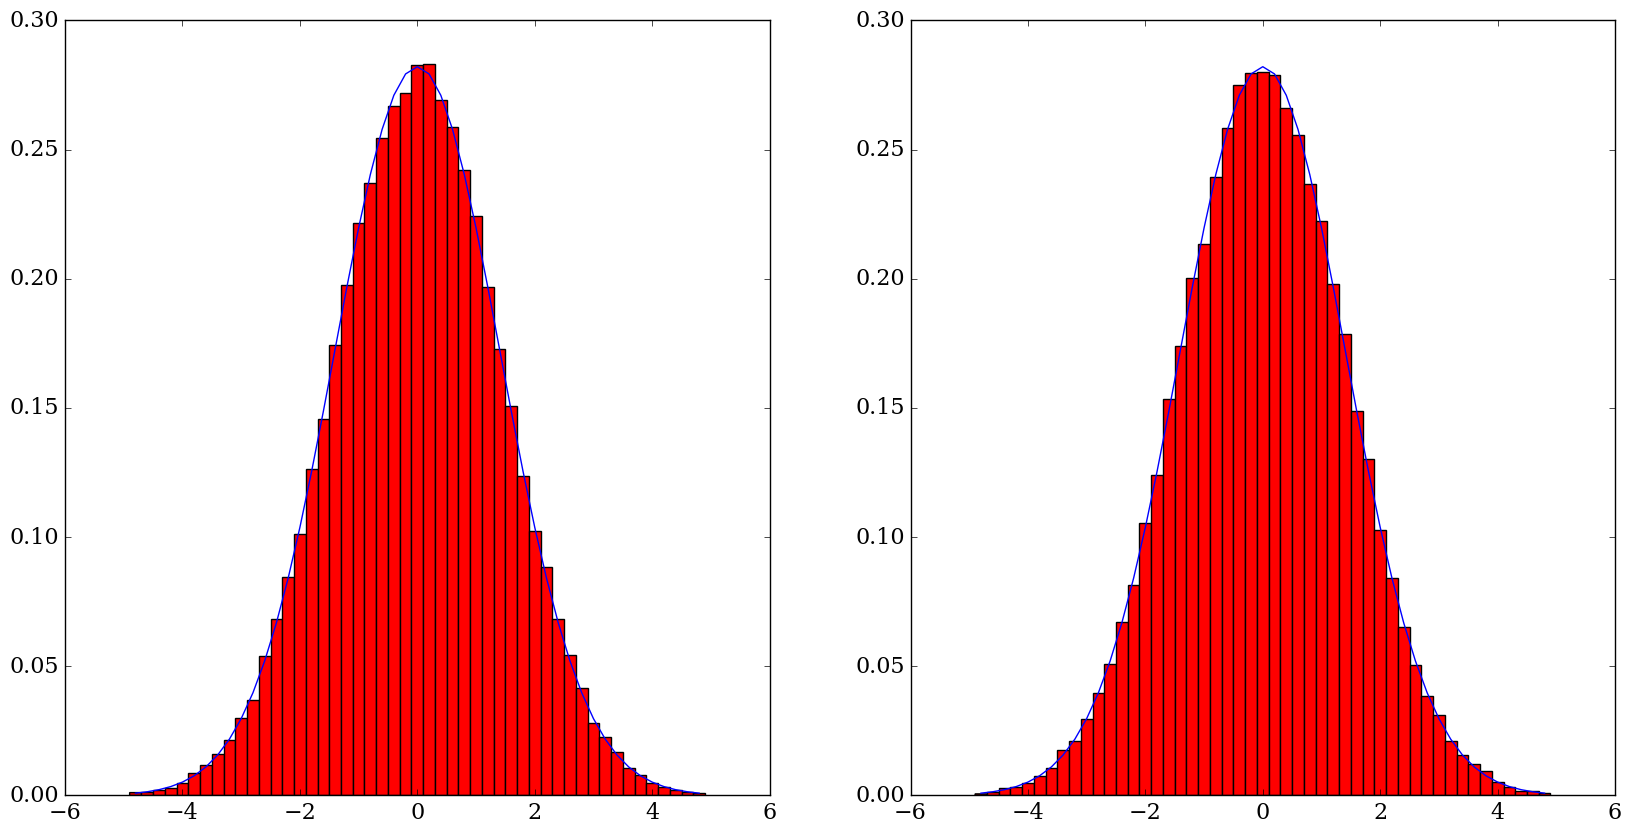

In [13]:
figure(figsize=(20,10))

subplot(1,2,1)
histfriction(xnt1)

subplot(1,2,2)
histfriction(xnt2)

Les graphiques sont effectivement très semblables, ils sont indépendants de la condition initiale.
Vérifions qu'ils ne dépendent que du rapport entre les valeurs $\alpha$ et $\gamma$. Gardons celui-ci égal à deux et modifions les coefficients et le temps total.

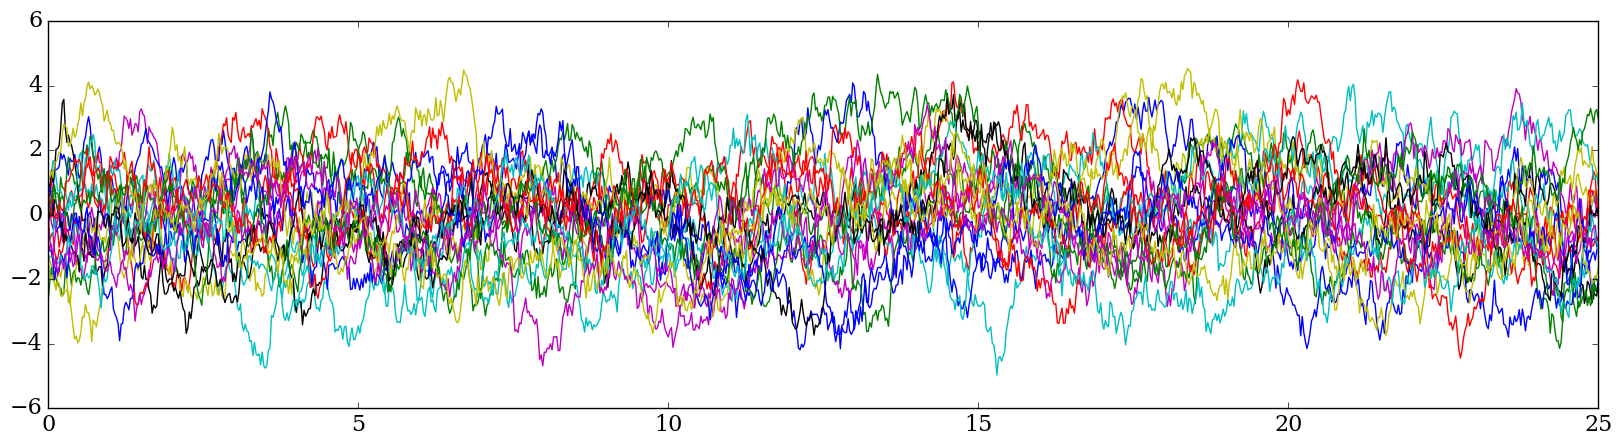

In [14]:
T=25                    
nt=1000                
mu = 0
sigma = 1.0
alpha= 2                
gamma= 1              
figure(figsize=(20,5))
xnt3 = trajfriction(T,nt,alpha,gamma,mu,sigma,npart)

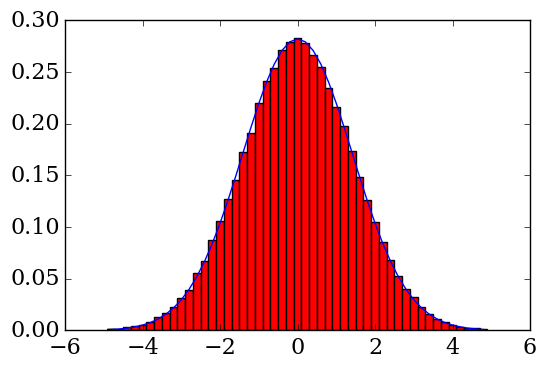

In [15]:
histfriction(xnt3)

Nos hypothèses sont donc bien cohérentes. Après un temps T suffisamment long, les distributions ne dépendent plus QUE du rapport entre les coefficients de diffusion et de friction.
La densité est donc donnée par:
$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_T^2}}e^{-\frac{(x-\mu_T)^2}{2\sigma_T^2}}
$$
Avec $\mu_T=0$ et $\sigma_T=\alpha/\gamma$

## Notebook 4

In [16]:
def initial_state(nx,ny): # Cette fonction remplit aléatoirement un tableau nx*ny par des -1 et des 1
    r = random.randint(0,2,(nx,ny))
    # Nous prenons r, qui prend aléatoirement 0 ou 1 pour valeur
    r[r==0] =-1
    # r=-1 si r a pris 0 comme valeur aléatoire

    return r

Dans l'image ci-dessous, chaque case représente un dipôle, et sa couleur représente son spin (+1 en rouge, -1 en bleu)

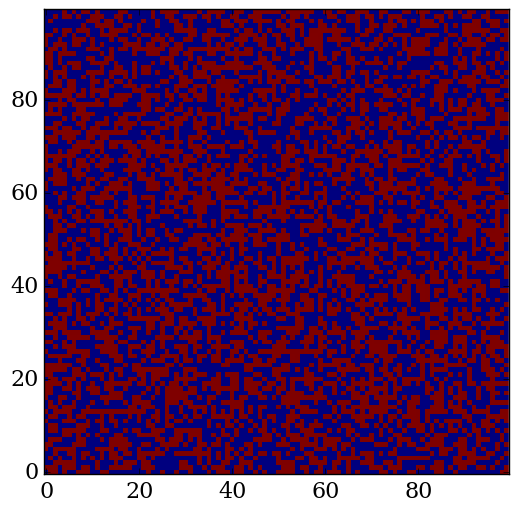

In [17]:
nx=100
ny=100
sp=initial_state(nx,ny)
alpha=0.1
figure(figsize=(6,6))
pyplot.imshow(sp,interpolation="none",origin='lower')

In [18]:
def energy_at_site(sp,alpha,sigma,ix,iy): # Cette fonction calcule l'énergie d'un site, soit d'un dipôle,
                                          # en calculant l'interaction de ce dipôle avec les dipôles voisins.
    energy = -alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy

L'énergie est calculée de la sorte:

$$\ E = -{\alpha} s_i \sum_{j \in n(i)} s_j$$ 

où ${\alpha}$ est J/(kb*T), $s_i$ est le spin du site qui nous intéresse et $s_j$ les spins des sites voisins.

Nous définissons ensuite une fonction qui calcule l'énergie d'un dipôle, qui change le sens du dipôle et recalcule son énergie après le changement de sens. La condition pour que ce changement de sens du dipôle soit permanent est que l'énergie ait diminuée. Sinon, il est accepté avec une probabilité:

$$p_{\rm flip}=e^{-\Delta E}$$

In [19]:
def metropolis_at_site(sp,alpha,ix,iy):
    
    sigma=sp[ix,iy]                                            # Sigma est la valeur du spin en (ix;iy)
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)  # Calcul de l'énergie avant le "flip"
    sigma = -sigma                                             # Changement de signe du spin
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy) # Calcul de l'énergie après le "flip"
                                                                  # Condition pour garder ce changement
    if (random.random_sample() < exp(-(energy_if_site_flipped -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

Nous savons que la probabilité de spin positif divisé par la probabilité de spin négatif est égale à l'exponentielle de l'opposé de la différence d'énergie. Nous avons donc:

$$\frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}$$

Vérifions que cela est bien vrai en utilisant d'abord la formule exponentielle, puis en effectuant le quotient des probabilités.

In [20]:
print(exp(-(energy_at_site(sp,alpha,-sp[7,1],7,1) - energy_at_site(sp,alpha,sp[7,1],7,1)))) 
# On calcule l'énergie en un point

1.0


In [21]:
NMC = 100000                  # Nous essayons NMC fois de faire un flip d'un certain dipôle et nous regardons le
states = numpy.empty(NMC+1)   # nombre de spins positifs et de spins négatifs obtenu. Effectuons ensuite le quotient
states[0]=sp[7,1]             # des deux.

for n in range(0,NMC):
    metropolis_at_site(sp,alpha,7,1)
    states[n]=sp[7,1]

ups = extract(states==1, states).size
downs = NMC - ups

print(ups/downs)

1.0


Nous voyons que les résultats sont les mêmes.

Nous définissons maintenant une fonction qui prend un système SP, et choisit nx*ny dipôles aléatoires en essayant à chaque fois de changer le signe du dipôle avec la fonction métropolis_at_site. Il fait une copie du sytème obtenu, et recommence le procédé NMC fois. Nous obtenons donc NMC états ayant changés suite à nx.ny possibles flips pour chacun des états.

In [22]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):

    states = numpy.empty([NMC+1,nx,ny])    # On crée une liste vide qui va contenir l'évolution du sytème entre chaque
    states[0] = sp.copy()                  # nx*ny essais aléatoires de flips.
    
    for i in range(1,NMC+1):               # Boucle créant NMC états du sytème.
        for j in range(0,nx*ny):           # Boucle qui tente de changer nx*ny dipôles choisis aléatoirement.
            ix=random.randint(0,nx)
            iy=random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()                # Copie de l'évolution du système
    return states

Nous allons maintenant créer une fonction permettant d'utiliser la fonction ising_model_metropolis pour créer NMC états, pour ensuite faire la moyenne de l'énergie et de la magnétisation sur ces NMC états. La fonction répète ce procédé NB fois, en faisant augmenter ${\alpha}$ de 1/NB à chaque répetition.

In [23]:
def energy_and_magnetisation_average(nx,ny,NB,NMC,sp):
    E = 0                           # Définition de l'énergie et de la magnétisation moyenne des NMC états pour un alpha
    M = 0
    alpha = numpy.linspace(0,1,NB)  # Liste reprenant les différentes valeurs que va prendre alpha
    energyaverage = numpy.empty(NB) # Liste où l'énergie moyenne est stockée pour chaque alpha
    maverage = numpy.empty(NB)      # Liste où la magnétisation moyenne est stockée pour chaque alpha
    
    for k in range (NB):            # Boucle faisant varier alpha
        spclone = sp.copy()
        states = ising_model_metropolis(sp,NMC,nx,ny,alpha[k]) # Création des NMC états par le Ising model
        for n in range (NMC+1):     # Pour chaque état, E somme l'énergie de chaque dipôle et M la magnétisation.
            for i in range (nx):
                for j in range (ny):
                    M = M+spclone[j,i]
                    E = E+energy_at_site(spclone,alpha[k],spclone[j,i],j,i)
        
            spclone = states[n]
        E = E/(NMC*nx*ny)    # Nous effectuons ensuite la moyenne de M et de E que nous ajoutons aux listes respectives
        M = M/(NMC*nx*ny)
    
        energyaverage[k] = E # Nous gardons chaque moyenne pour chaque alpha et réinitialisons E et M
        maverage[k] = M
        E = 0
        M = 0
        
    pyplot.figure(figsize=(12,8))
    
    pyplot.plot(alpha,energyaverage,label=r'$E$')
    pyplot.plot(alpha,maverage,label=r'$M$')
    pyplot.legend()
    pyplot.tight_layout()

### Remarque préalable 
Notons que le code ci-dessous fonctionne sur les ordinateurs des salles informatiques mais a parfois fait planter nos ordinateurs portables.

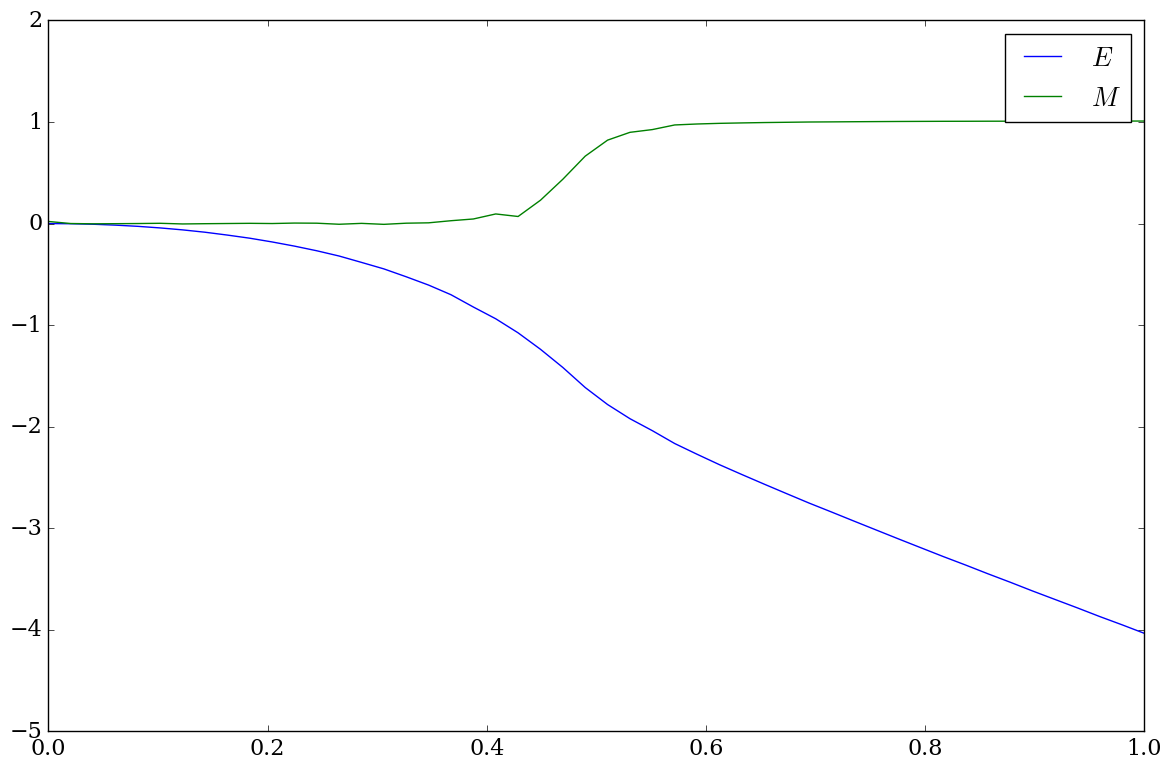

In [32]:
nx = 100
ny = 100
NB = 50
NMC = 100
sp = numpy.ones([nx,ny])
energy_and_magnetisation_average(nx,ny,NB,NMC,sp)

La fonction ci-dessus part d'un état où tout les spins sont positifs. Voici le graphique de l'énergie moyenne et la magnétisation moyenne en fonction de alpha.

Nous remarquons qu'au plus ${\alpha}$ augmente, au plus l'énergie décroit et au plus la magnétisation tend vers 1. En effet, ${\alpha}$ est proportionnel à l'inverse de la température, donc au plus il est proche de 0, au plus la température est élevée et donc la disposition des dipôles est plus aléatoire (par agitation thermique). A l'inverse, si ${\alpha}$ est proche de 1, la température est basse et donc les dipôles sont plus enclins à être tous dans la même orientation.

In [29]:
NMC=100
alpha=0.2
sp = numpy.ones([nx,ny])
states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha)
NMC=100
sp = numpy.ones([nx,ny])
alpha=0.7
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha)

Nous remarquons la même chose si nous analysons l'évolution du magnétisme pour chaque état créé par la fonction ising_model_metropolis pour un ${\alpha}$ fixé. Pour ${\alpha}=0.2$ le magnétisme tend très vite vers 0 (donc orientation aléatoire) et pour ${\alpha}=0.7$ le magnétisme reste constant (donc ordonné). Notons que nous partons d'états entièrement composés de dipôles positifs.

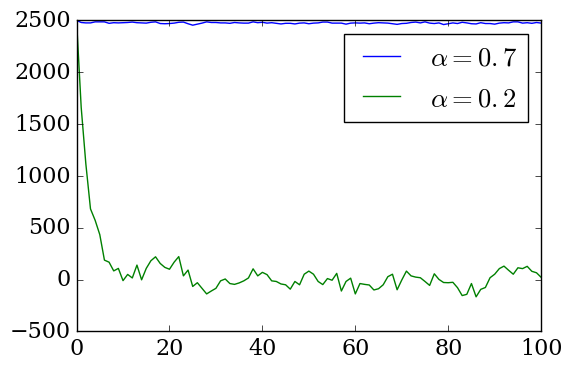

In [30]:
figure()
plot(states_0_7.sum(axis=(1,2)),label=r'$\alpha=0.7$')
plot(states_0_2.sum(axis=(1,2)),label=r'$\alpha=0.2$')
pyplot.legend()
pyplot.tight_layout()

Refaisons la fonction energy and magnetisation average en partant d'un état aléatoire à l'intérieur de la surface mais de spins positifs sur les bords. Regardons le graphique des moyennes de l'énergie et de la magnétisation en fonction de ${\alpha}$.

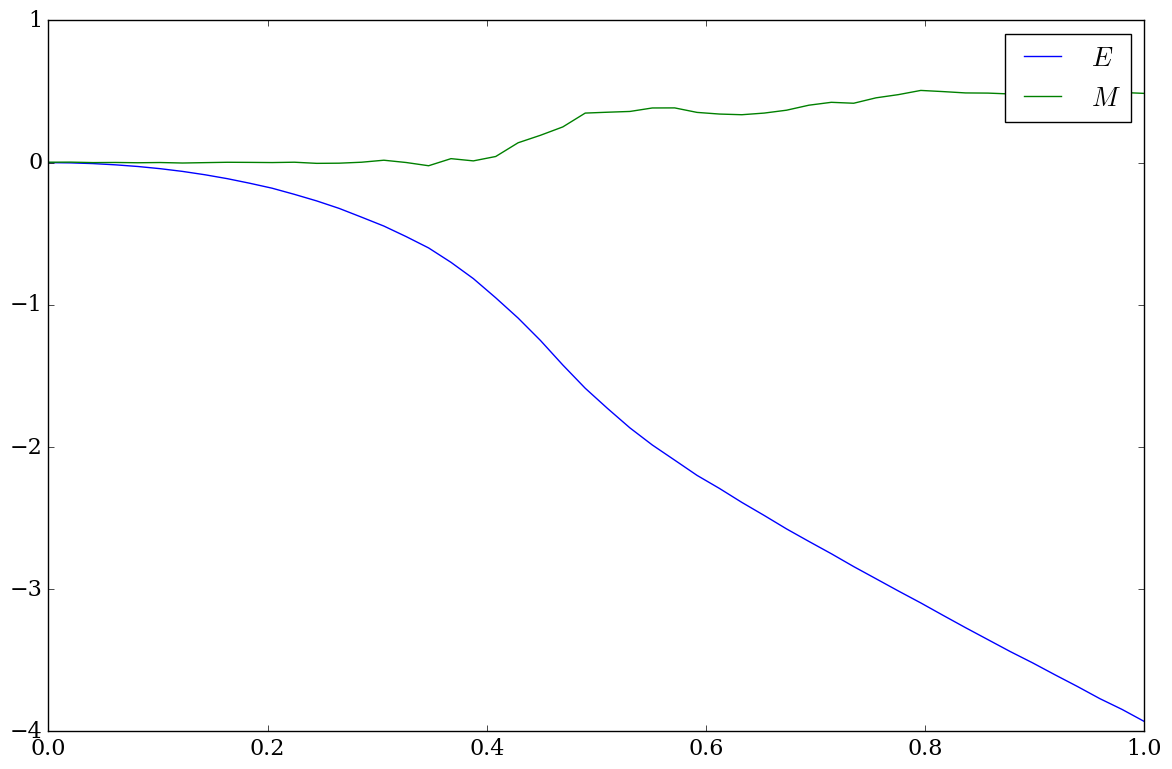

In [33]:
nx = 100
ny = 100
NMC = 100
NB = 50
sp = initial_state(nx,ny)     # Création de l'état initial
for i in range(0,nx):
    sp[i,0] = 1
    sp[i,nx-1] = 1
    sp[0,i] = 1
    sp[ny-1,i] = 1
energy_and_magnetisation_average(nx,ny,NB,NMC,sp)

### Conclusion 

Nous arrivons à la même conclusion que précédemment. Nous remarquons par ces deux graphiques que la magnétisation cesse d'être constante (autour de 0) à partir de ${\alpha}$ = 0.45 (approximativement) ce qui correspond à la solution exacte d'Onsager qui est de ${\alpha}$ = 0.44.

Remarquons aussi qu'une fois cette solution dépassée, l'énergie tend vers une droite de pente ${-\alpha}$ . Ceci est normal étant donné que l'énergie est inversément proportionelle à ${\alpha}$.